In [76]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1000)

In [77]:
class Layer:
    def __init__(self,dims,previous_layer=None,init_method='random_normal',activation='linear'):
        """
        parameters
        dims             : dims is a tuple containing two values (input_size, output_size)
        previous_layer   : instance of a previous layer
        init_method      : initialization method
        activation       : activation function. Only linear and Tanh have been implemented at the moment
        """
        self.dims = dims
        self.activation_func = activation
        self.previous_layer = None
        self.outs = None
        self.ins = None
        if previous_layer is not None:
            if previous_layer.dims[1] != self.dims[0]:
                raise Exception("Layers can't be attached!, {} != {}".format(previous_layer.dims[1],self.dims[0]))
            self.weights = np.random.normal(size=self.dims)
            self.bias = np.random.normal(size=(self.dims[1]))
            self.previous_layer = previous_layer
        else:
            self.weights = np.random.normal(size=self.dims)
            self.bias = np.random.normal(size=(self.dims[1]))
            
    def forward_prop(self,inputs):
        return inputs @ self.weights + self.bias
    
    def activation(self,inputs):
        if self.activation_func == 'tanh':
            return np.tanh(inputs)
        else:
            return inputs
        
    def derivative_of_activation(self,inputs):
        if self.activation_func == 'tanh':
            return 1 - self.activation(inputs)**2
        elif self.activation_func == 'linear':
            return np.ones(inputs.shape)
        else:
            pass
        
    def gradient_descent(self,grads_w, grads_b, steps):
        self.weights -= steps*grads_w
        self.bias -= steps*grads_b
        
    def calc_prev_layer_error(self,derivative,weights,error):
        N,M = derivative.shape
        Sum = np.zeros((M,N))
        for i in range(N):
            Is = np.zeros((N,N))
            Ir = np.zeros((N,N))
            Is[0][i] = 1
            Ir[i][i] = 1
            Sum += np.diag((Is @ derivative)[0][:])@((weights @ error) @ Ir)
        return Sum
    
    def back_prop(self,error,steps):
        if self.previous_layer is None:
            
            #compute gradients
            grads_w = error @ self.ins
            grads_b = np.sum(error,axis=1)
            #update weights with gradient descent
            self.gradient_descent(grads_w.T,grads_b,steps)
        else:
            #compute derivatives
            d = self.previous_layer.derivative_of_activation(self.previous_layer.outs)
            #estimate previous layer error
            layer_error = self.calc_prev_layer_error(d,self.weights,error)
            
            #Compute gradients
            grads_w = error @ self.previous_layer.activation(self.ins)
            grads_b = np.sum(error,axis=1)
            
            self.gradient_descent(grads_w.T, grads_b, steps)

            self.previous_layer.back_prop(layer_error,steps)
        
        
    def __call__(self,inputs):
        if self.previous_layer is None:
            self.ins = inputs
            self.outs = self.forward_prop(self.ins)
            return self.activation(self.outs)
        else:
            self.ins = self.previous_layer(inputs)
            self.outs = self.forward_prop(self.ins)
            return self.activation(self.outs)

In [78]:
class Data:
    def __init__(self,X,y,batch_size):
        self.batch_size =  batch_size
        self.X = X
        self.y = y
    def __next__(self):
        choices = np.random.choice(self.X.shape[0],self.batch_size)
        x_ = self.X[choices]
        y_ = self.y[choices]
        return x_, y_
        

In [79]:
class Model:
    def __init__(self,network,loss_func='rms'):
        self.network = network
        self.loss_func = loss_func
    def fit(self,generator, epochs=10,steps=0.1):
        """
        This function is responsible for the training of the NN
        Params
        generator    : Instance of a data generator class
        epochs       : Number of training epochs
        steps        : step size for gradient descent
        """
        for epoch in range(epochs):
            x_train, y_train = next(generator)
            #forward propagation
            y = self.network(x_train)
            error_sigma = self.loss(y,y_train)
            #Error backpropagation
            self.network.back_prop(error_sigma,steps)
            Error = self.error(y,y_train)
            print("Epoch: {}  Loss: {}".format(epoch,Error))
            
    def loss(self,y,t):
        if self.loss_func == 'rms':
            return (y - t).T
        elif self.loss_func == 'logits':
            pass
    def error(self,y,t):
        if self.loss_func == 'rms':
            e = (y - t)**2
            e = 0.5*np.mean(e)
            return np.sqrt(e)
        
    def predict(self,X_test):
        return self.network(X_test)

In [80]:
def f(x):
    return np.sin(2*x) + np.cos(x)+ 5

In [81]:
#Dataset size
N = 10000
#Real process data
x = np.linspace(-5,5,1000).reshape(-1,1)
y = f(x)
#Data and parameter (i.e. prior) standard deviations
sigma_data = 0.2
sigma_params = 0.5

#simulate noise in measurements
data_noise = np.random.normal(0, sigma_data, N).reshape(-1,1)

#Generate training data i.e x
X_train = np.random.uniform(-5,5,N).reshape(-1,1)
Y_train = f(X_train) + data_noise

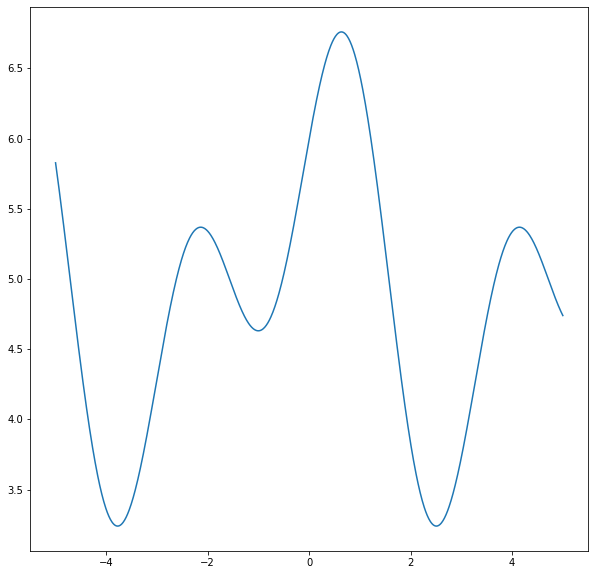

In [82]:
plt.figure(figsize=(10,10))
plt.plot(x,y,label="Real process")
# plt.legend()
plt.show()

In [83]:
#Create network
L1 = Layer((1,12),activation='tanh')
L2 = Layer((12,32),L1, activation='tanh')
L3 = Layer((32,12),L2, activation='tanh')
network = Layer((12,1),L3)

model = Model(network)
batch_size = 100
datagen = Data(X_train,Y_train,batch_size)

#Training
model.fit(datagen,epochs=1000,steps=0.0001)

Epoch: 0  Loss: 3.904802590402042
Epoch: 1  Loss: 3.1830467098291937
Epoch: 2  Loss: 2.17349169380639
Epoch: 3  Loss: 1.834758341688934
Epoch: 4  Loss: 1.72608557412452
Epoch: 5  Loss: 1.395792807240209
Epoch: 6  Loss: 0.9264621836752964
Epoch: 7  Loss: 0.8002976142081987
Epoch: 8  Loss: 0.8650686621543617
Epoch: 9  Loss: 0.7329435466119423
Epoch: 10  Loss: 0.7705927685023716
Epoch: 11  Loss: 0.7123002633002778
Epoch: 12  Loss: 0.7206529208224295
Epoch: 13  Loss: 0.7459805194738658
Epoch: 14  Loss: 0.793984043641758
Epoch: 15  Loss: 0.6628380856640546
Epoch: 16  Loss: 0.6772242976575077
Epoch: 17  Loss: 0.7604268467611778
Epoch: 18  Loss: 0.6928944931213199
Epoch: 19  Loss: 0.7506510673894213
Epoch: 20  Loss: 0.6728819176529839
Epoch: 21  Loss: 0.7290304700367026
Epoch: 22  Loss: 0.668662028250499
Epoch: 23  Loss: 0.6776354616668115
Epoch: 24  Loss: 0.6609556955387033
Epoch: 25  Loss: 0.6741505875714549
Epoch: 26  Loss: 0.6337310846220845
Epoch: 27  Loss: 0.6367454755889093
Epoch: 28  

Epoch: 228  Loss: 0.2637631868357684
Epoch: 229  Loss: 0.26041381976066175
Epoch: 230  Loss: 0.22504264180243574
Epoch: 231  Loss: 0.2679289698642203
Epoch: 232  Loss: 0.2569588257410841
Epoch: 233  Loss: 0.21897894989854708
Epoch: 234  Loss: 0.2689577637756191
Epoch: 235  Loss: 0.2643963567856179
Epoch: 236  Loss: 0.25354646460381525
Epoch: 237  Loss: 0.24820042420934482
Epoch: 238  Loss: 0.2313417388144127
Epoch: 239  Loss: 0.23690272058105893
Epoch: 240  Loss: 0.23693051989103764
Epoch: 241  Loss: 0.253816469459903
Epoch: 242  Loss: 0.2449975326109383
Epoch: 243  Loss: 0.2518688416507497
Epoch: 244  Loss: 0.24091621954630124
Epoch: 245  Loss: 0.2255864364106831
Epoch: 246  Loss: 0.24256247774430664
Epoch: 247  Loss: 0.2644358569022725
Epoch: 248  Loss: 0.22155759558710011
Epoch: 249  Loss: 0.2530786301611826
Epoch: 250  Loss: 0.20568540421273865
Epoch: 251  Loss: 0.2281827623022852
Epoch: 252  Loss: 0.2274631246808074
Epoch: 253  Loss: 0.24011950524256914
Epoch: 254  Loss: 0.2528117

Epoch: 447  Loss: 0.23351604698231096
Epoch: 448  Loss: 0.20237692835933782
Epoch: 449  Loss: 0.17408621241792333
Epoch: 450  Loss: 0.20184556812599008
Epoch: 451  Loss: 0.1939900679533269
Epoch: 452  Loss: 0.1978781389915136
Epoch: 453  Loss: 0.19718406418965012
Epoch: 454  Loss: 0.16701739661877818
Epoch: 455  Loss: 0.23354113491295794
Epoch: 456  Loss: 0.18361002392851689
Epoch: 457  Loss: 0.1853743925880217
Epoch: 458  Loss: 0.2052231771903704
Epoch: 459  Loss: 0.1796239617104629
Epoch: 460  Loss: 0.19739140997826385
Epoch: 461  Loss: 0.20814924733393925
Epoch: 462  Loss: 0.2148209752945062
Epoch: 463  Loss: 0.18713031894212726
Epoch: 464  Loss: 0.2257926376477553
Epoch: 465  Loss: 0.2527027631728107
Epoch: 466  Loss: 0.22059790815615893
Epoch: 467  Loss: 0.19487495774643573
Epoch: 468  Loss: 0.20676088663687409
Epoch: 469  Loss: 0.21820416864121378
Epoch: 470  Loss: 0.19630818465379374
Epoch: 471  Loss: 0.1814271986864527
Epoch: 472  Loss: 0.1976276076428473
Epoch: 473  Loss: 0.21

Epoch: 668  Loss: 0.212593157502263
Epoch: 669  Loss: 0.1950152289635849
Epoch: 670  Loss: 0.19490531277901868
Epoch: 671  Loss: 0.21300297284512898
Epoch: 672  Loss: 0.182181973906989
Epoch: 673  Loss: 0.18397758822151694
Epoch: 674  Loss: 0.1989450895855895
Epoch: 675  Loss: 0.19339852419839657
Epoch: 676  Loss: 0.20421563256086986
Epoch: 677  Loss: 0.1861017226915978
Epoch: 678  Loss: 0.20341639826822933
Epoch: 679  Loss: 0.18617974245507193
Epoch: 680  Loss: 0.18422118956352726
Epoch: 681  Loss: 0.1614298191191498
Epoch: 682  Loss: 0.19433859368184314
Epoch: 683  Loss: 0.1925120331997495
Epoch: 684  Loss: 0.18512196110872067
Epoch: 685  Loss: 0.1787150064346808
Epoch: 686  Loss: 0.19344730799137813
Epoch: 687  Loss: 0.19397011268967385
Epoch: 688  Loss: 0.23542292393591885
Epoch: 689  Loss: 0.1882697052419232
Epoch: 690  Loss: 0.18382391096250564
Epoch: 691  Loss: 0.21063815230637384
Epoch: 692  Loss: 0.17483548387391615
Epoch: 693  Loss: 0.18186279050893556
Epoch: 694  Loss: 0.197

Epoch: 889  Loss: 0.18068012600979289
Epoch: 890  Loss: 0.1867242453192002
Epoch: 891  Loss: 0.17417436995530278
Epoch: 892  Loss: 0.19654221814064035
Epoch: 893  Loss: 0.1728151159832983
Epoch: 894  Loss: 0.19121032988784512
Epoch: 895  Loss: 0.19637019720315285
Epoch: 896  Loss: 0.17002909128518734
Epoch: 897  Loss: 0.15975436113177902
Epoch: 898  Loss: 0.17306578137818848
Epoch: 899  Loss: 0.18016110172389366
Epoch: 900  Loss: 0.1676557274884741
Epoch: 901  Loss: 0.20317702859338102
Epoch: 902  Loss: 0.16983826707282768
Epoch: 903  Loss: 0.1559532738557092
Epoch: 904  Loss: 0.1780670921922646
Epoch: 905  Loss: 0.18381252348733915
Epoch: 906  Loss: 0.17996252223853912
Epoch: 907  Loss: 0.17719701467742535
Epoch: 908  Loss: 0.17466418783240903
Epoch: 909  Loss: 0.18372278258545144
Epoch: 910  Loss: 0.17890073696518036
Epoch: 911  Loss: 0.15367241341719734
Epoch: 912  Loss: 0.19042906296953416
Epoch: 913  Loss: 0.20239816949895356
Epoch: 914  Loss: 0.2054822847750107
Epoch: 915  Loss: 

In [59]:
#model.fit(datagen,epochs=100,steps=0.0005)

In [84]:
X_test = np.linspace(-5,5,1000).reshape(-1,1)
predicted = model.predict(X_test)

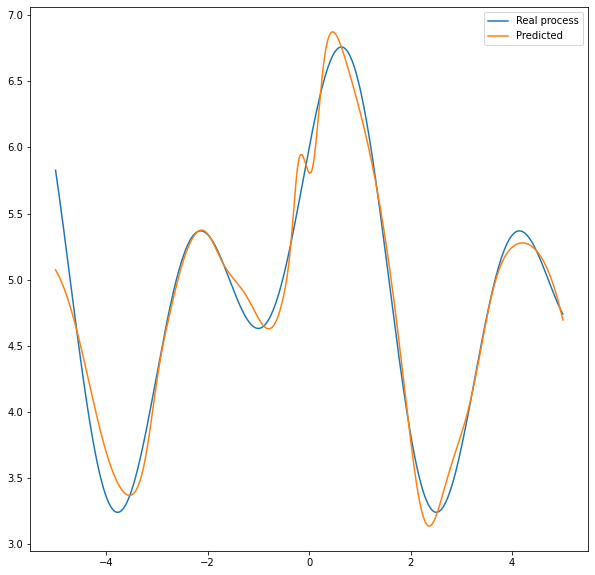

In [85]:
plt.figure(figsize=(10,10))
plt.plot(x,y,label="Real process")
plt.plot(X_test,predicted,label="Predicted")
plt.legend()
plt.show()